# 📈 Bitcoin Price Forecasting Using Deep Learning

*Predicting the future price of Bitcoin using linear and recurrent neural network models.*

## Executive Summary

Bitcoin (BTC) is d widely traded cryptocurrency, making it a popular subject for time series forecasting. In this project, we aim to predict the **future closing price** of Bitcoin one hour ahead using historical price data.

We use a **supervised learning approach** to train and evaluate multiple mo, s — starting from simple baselines to more advanced neural networks. Each model uses the **past 24 hours of Bitcoin data** (at 1-minute intervals) as input to predict the **closing price one hour into the future**

#### Objectives:
- Preprocess raw BTC price data and select relevant features
- Create sliding time windows for model training using TensorFlow
- Implement and evaluate a **baseline model** (predict last seen value)
- Implement and evaluate a **linear model**
- Implement and evaluate an **RNN model (LSTM)**
- Visualize actual vs. predicted prices
- Compare model performance using validation and test metrics

This project provides a practical, interpretable, and replicable approach for time series forecasting of cryptocurrency prices using modern machine arning tools.



## Data Loading & Exploratory Data Analysis

To build effective forecasting models, it's crucial to understand the structure, quality, and patterns in the data. In this section, we:

- Load minute-level Bitcoin data from Coinbase
- Inspect the structure of the dataset
- Clean any missing or invalid entries
- Explore key features such as price trends and volume over time
- Examine correlations between features to guide feature selection

The dataset includes the following columns:

- `Timestamp`: Start time of the 60-second window (in Unix time)
- `Open`: Price at the beginning of the minute
- `High`: Highest price during the minute
- `Low`: Lowest price during the minute
- `Close`: Price at the end of the minute
- `Volume_(BTC)`: Total BTC traded in that minute
- `Volume_(Currency)`: Total USD traded in that minute
- `Weighted_Price`: Volume-weighted average price

## Data Loading and Exploratory Data Analysis

### 🔹 Load and Inspect the Dataset

We begin by loading minute-level Bitcoin trading data from the `coinbase.csv` file. This dataset contains key trading metrics such as open, high, low, close prices, volume, and weighted price. After loading, we inspect the first few rows to understand its structure and check for any missing values that need to be handled.


In [4]:
# Step 1: Load the dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set display and plot styles
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Load CSV data
data = pd.read_csv('coinbase.csv')

# Display the first few rows
print("First few rows of the dataset:")
display(data.head())

# Step 2: Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

First few rows of the dataset:


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0000,300.0000,300.0000,300.0000,0.0100,3.0000,300.0000
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Missing values per column:
Timestamp                 0
Open                 109069
High                 109069
Low                  109069
Close                109069
Volume_(BTC)         109069
Volume_(Currency)    109069
Weighted_Price       109069
dtype: int64


### Handling Missing Values

A significant portion of the dataset, that is over 100,000 rows—contained missing values across all major price and volume-related columns. These rows will be removed to ensure the integrity of the training data. The remaining data is clean and ready for analysis and modeling.


### Price and Volume Trends Over Time

To understand the dynamics of Bitcoin trading activity, we plotted the closing price and transaction volume over time. The `Timestamp` column was converted to human-readable datetime format for clarity. 

- The **closing price** plot helps us visualize periods of volatility and stability.
- The **volume (BTC)** plot reveals trading activity levels, which can be a useful signal for forecasting.

These trends provide a foundation for selecting useful features and choosing appropriate modeling strategies.


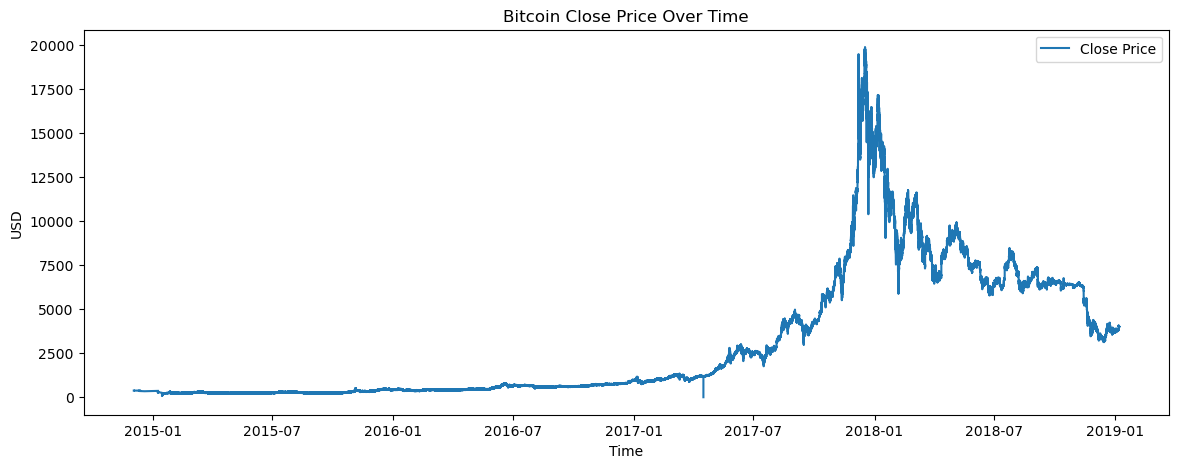

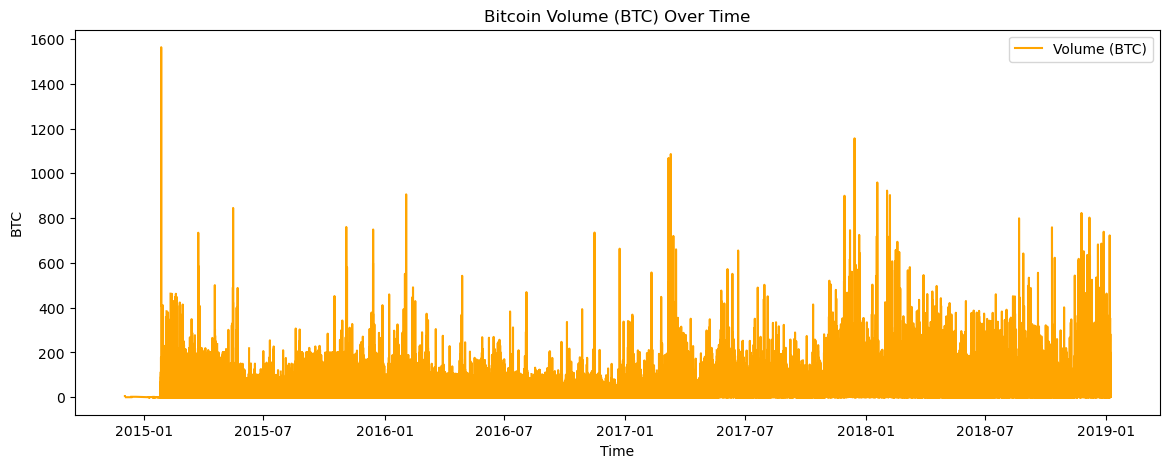

In [7]:
# Plot key features - Price and Volume over time
# Convert Unix timestamp to readable datetime for plotting
data['Datetime'] = pd.to_datetime(data['Timestamp'], unit='s')

# Plot 'Close' price over time
plt.figure(figsize=(14, 5))
plt.plot(data['Datetime'], data['Close'], label='Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.xlabel('Time')
plt.ylabel('USD')
plt.legend()
plt.show()

# Plot 'Volume_(BTC)' over time
plt.figure(figsize=(14, 5))
plt.plot(data['Datetime'], data['Volume_(BTC)'], label='Volume (BTC)', color='orange')
plt.title('Bitcoin Volume (BTC) Over Time')
plt.xlabel('Time')
plt.ylabel('BTC')
plt.legend()
plt.show()

### Correlation Analysis

To identify redundant or highly related features, we computed a correlation matrix of all numerical columns and visualized it using a triangular heatmap. 

- Strong correlations (near ±1) indicate features that carry overlapping information.
- As expected, the price-related features (`Open`, `High`, `Low`, `Close`, and `Weighted_Price`) are almost perfectly correlated.
- To avoid multicollinearity and reduce dimensionality, we will retain only a subset, specifically `Close` and `Volume_(BTC)`—for model training.


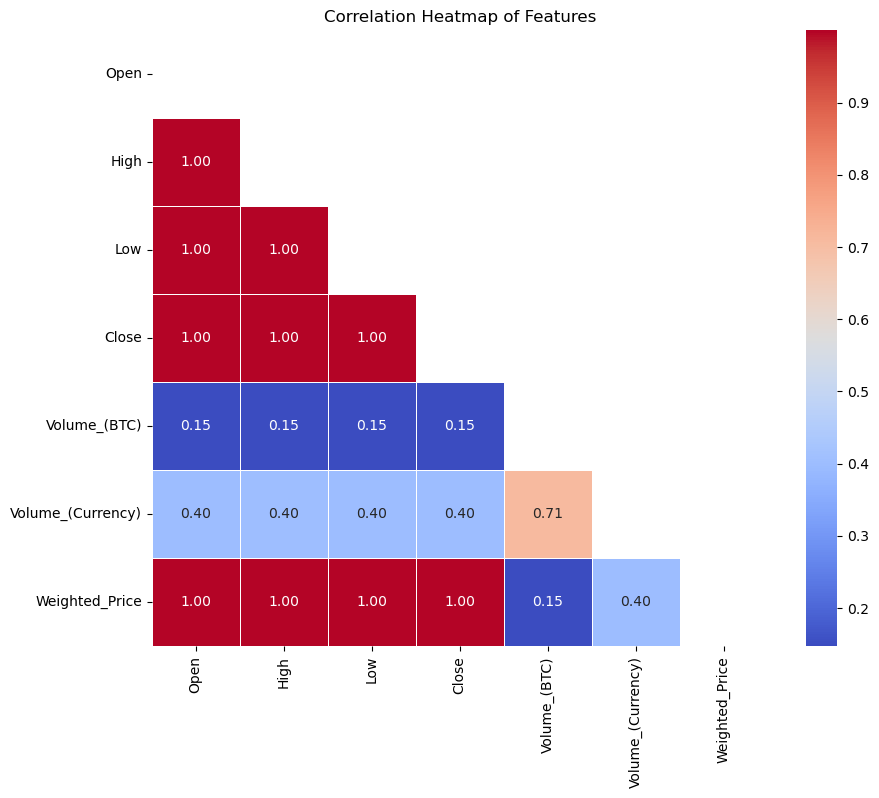

In [9]:
import numpy as np

corr_data = data.drop(columns=['Timestamp', 'Datetime'])

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", square=True, linewidths=.5)
plt.title('Correlation Heatmap of Features')
plt.show()

###  Normalize the Data

Bitcoin prices and trading volumes operate on very different scales. For example, the `Close` price can range in the tens of thousands, while `Volume_(BTC)` may range in single or double digits.

Neural networks are sensitive to input sc: les—features with larger values can dominate the learning process and slow down convergence. To ensure stable and balanced training, we apply **Z-score normalization** using the **mean and standard deviation from the training set**. This brings all features to a similar scale while preserving their relationships.


###  Data Preprocessing Summary

Based on our exploratory data analysis, we perform the following preprocessing steps to prepare the data for modeling:

- Remove rows with missing values to ensure clean, consistent data.
- Select only the key features `Close` price and `Volume_(BTC)` due to their strong predictive potential and to reduce redundancy.
- Split the dataset chronologically into training (70%), validation (20%), and testing (10%) sets to maintain temporal order.
> **Note:** Since Bitcoin price data is time series data, it’s crucial to preserve the chronological order when splitting. This prevents future data points from leaking into the training set, which would lead to overly optimistic performance estimates and unrealistic predictions. Using a temporal split simulates real-world forecasting where the model predicts unseen future data based on past observations.- Apply **Z-score normalization** using the training set's mean and standard deviation to scale features uniformly, improving model convergence.



The resulting datasets are ready for model training and evaluation.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def preprocess_data():
    # Load dataset
    data = pd.read_csv("coinbase.csv")
    
    # Drop rows with missing values
    data = data.dropna()

    # Keep only 'Close' and 'Volume_(BTC)'
    data = data[['Close', 'Volume_(BTC)']]
    
    # Split dataset: 70% train, 20% val, 10% test
    data_length = len(data)
    train_data = data[:int(data_length * 0.7)]
    valid_data = data[int(data_length * 0.7):int(data_length * 0.9)]
    test_data = data[int(data_length * 0.9):]

    # Normalize data based on train set stats
    train_mean = train_data.mean()
    train_std = train_data.std()

    train_data = (train_data - train_mean) / train_std
    valid_data = (valid_data - train_mean) / train_std
    test_data = (test_data - train_mean) / train_std
    
    return train_data, valid_data, test_data

train_data, valid_data, test_data = preprocess_data()


### Visualizing Normalized Bitcoin Close Price Across Dataset Splits

This chart shows the Bitcoin closing price after scaling (normalization) for the training, validation, and test sets. We normalize using the training data so the model learns better and faster. Plotting the price over time helps us check that the data is split correctly in order and that each part (train, validation, test) has similar patterns. This is important to make sure the model will work well on new data.


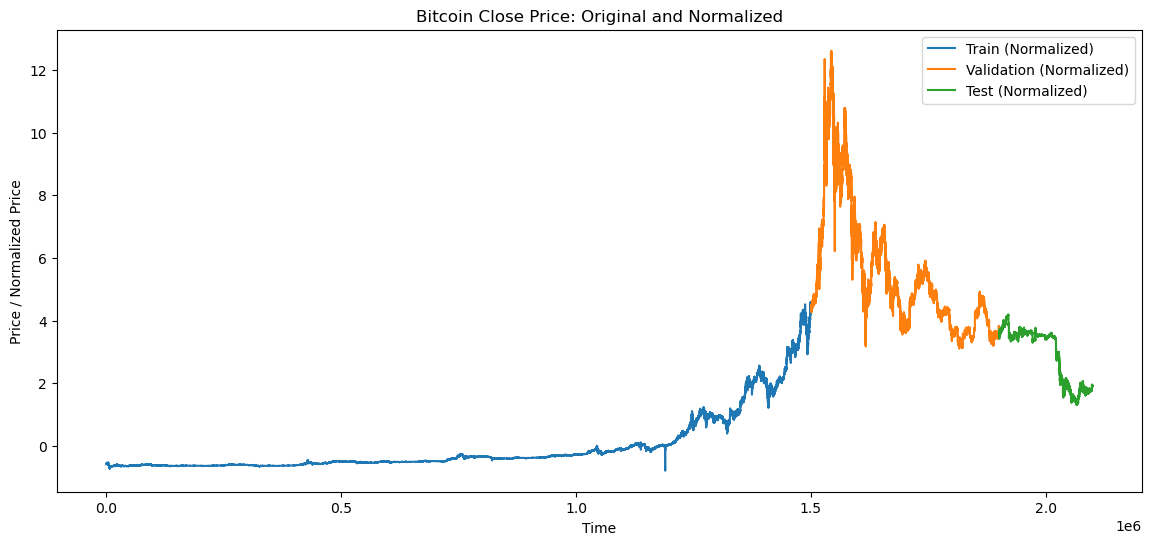

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Normalized Close Price for train/val/test (with datetime index if available)
plt.plot(train_data.index, train_data['Close'], label='Train (Normalized)')
plt.plot(valid_data.index, valid_data['Close'], label='Validation (Normalized)')
plt.plot(test_data.index, test_data['Close'], label='Test (Normalized)')

plt.title('Bitcoin Close Price: Original and Normalized')
plt.xlabel('Time')
plt.ylabel('Price / Normalized Price')
plt.legend()
plt.show()


## Creating Data Windows for Supervised Learning

To train models on time series data, we must convert the continuous stream of values into supervised learning samples. This is done using a **sliding window** approach, where each sample contains:

* a sequence of past values (inputs), and
* the future value(s) we want to predict (labels).

This approach enables the model to learn temporal patterns and make forecasts based on historical trends.


### What the `WindowGenerator` Does

* Converts raw time series data into fixed-size input-label pairs.
* Handles training, validation, and test datasets consistently.
* Automatically slices windows from the data based on:

  * `input_width`: number of past time steps (e.g., 1440 minutes = 24 hours),
  * `label_width`: number of steps to predict,
  * `shift`: how far into the future to predict (e.g., 60 minutes ahead).
* Supports selecting specific label columns (e.g., only `'Close'` price).

This windowed data format is essential for training models like Linear Regression or Recurrent Neural Networks on time-dependent data.

### Visualizing Input, Label, and Predictions

To better understand how well our models are learning, we use a custom `plot()` function to visualize:

* the **input sequence** the model sees,
* the **actual future value** (label) it's supposed to predict,
* and the **model's prediction** (if provided).


### What the `plot()` Function Does

* Extracts a small batch of example windows from the dataset.
* For each subplot:

  * Plots the input values over time (`Inputs`).
  * Highlights the true future value (`Labels`) as green dots.
  * Adds predicted values from the model (`Predictions`) as orange crosses.
* Helps us visually compare how close model predictions are to real outcomes.

> This plot is especially useful for spotting:
>
> * How much context (input) the model uses to predict
> * Lag, overshooting, or underfitting in predictions
> * Model behavior on different samples within a batch

In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_data, valid_data, test_data, label_columns=None):
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_data.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_data)

    @property
    def val(self):
        return self.make_dataset(self.valid_data)

    @property
    def test(self):
        return self.make_dataset(self.test_data)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

def plot(self, model=None, plot_col='Close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        
        # Plot inputs
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        # Get label column index
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        # Plot label values as a LINE
        plt.plot(self.label_indices, labels[n, :, label_col_index],
                 label='Labels', color='green')

        if model is not None:
            predictions = model(inputs)
            pred = predictions[n, :, label_col_index]

            # Convert to numpy
            if tf.is_tensor(pred):
                pred = pred.numpy()

            x_vals = self.label_indices
            y_vals = pred

            # Align lengths if needed
            min_len = min(len(x_vals), len(y_vals))
            x_vals = x_vals[:min_len]
            y_vals = y_vals[:min_len]

            # Plot predictions as points
            plt.scatter(x_vals, y_vals, marker='X', edgecolors='k',
                        label='Predictions', c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [steps]')
    plt.tight_layout()
    plt.show()


# Create the window generator instance:
window = WindowGenerator(
    input_width=1440,  # past 24 hours (1440 minutes)
    label_width=1,     # predict 1 time step (1 minute)
    shift=60,          # predict 60 minutes ahead (1 hour)
    train_data=train_data,
    valid_data=valid_data,
    test_data=test_data,
    label_columns=['Close']
)

## Train a Baseline Linear Model

To establish a simple and interpretable baseline, we start by training a **linear model**. This model predicts the future value (e.g., Bitcoin price) as a **weighted sum of the input features**, without any temporal memory like in RNNs or LSTMs.

### Why a Linear Model?

* Fast to train and easy to interpret
* Helps set a baseline for evaluating more complex models later (e.g., RNNs)
* Useful to identify whether the data has simple linear patterns or needs more advanced techniques

### Key Steps:

* We define a `Sequential` model with a single `Dense` layer that outputs one prediction.
* Use `Mean Squared Error (MSE)` as the loss and `Mean Absolute Error (MAE)` as a metric.
* Employ `EarlyStopping` to prevent overfitting by stopping training if the validation loss doesn't improve after a few epochs.
* Train the model using the preprocessed and windowed dataset we created earlier.

This step helps us evaluate how well a basic model can perform before moving on to more sophisticated architectures like RNNs.

In [19]:
import tensorflow as tf

# Define the linear model
linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

MAX_EPOCHS = 3

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )
    return history

# Train the linear model
history = compile_and_fit(linear_model, window)

Epoch 1/3
43500/43500 ━━━━━━━━━━━━━━━━━━━━ 194s 4ms/step - loss: 0.2927 - mean_absolute_error: 0.1507 - val_loss: 0.0914 - val_mean_absolute_error: 0.1843
Epoch 2/3
43500/43500 ━━━━━━━━━━━━━━━━━━━━ 195s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0169 - val_loss: 0.0908 - val_mean_absolute_error: 0.1831
Epoch 3/3
43500/43500 ━━━━━━━━━━━━━━━━━━━━ 197s 5ms/step - loss: 0.0019 - mean_absolute_error: 0.0169 - val_loss: 0.0910 - val_mean_absolute_error: 0.1836


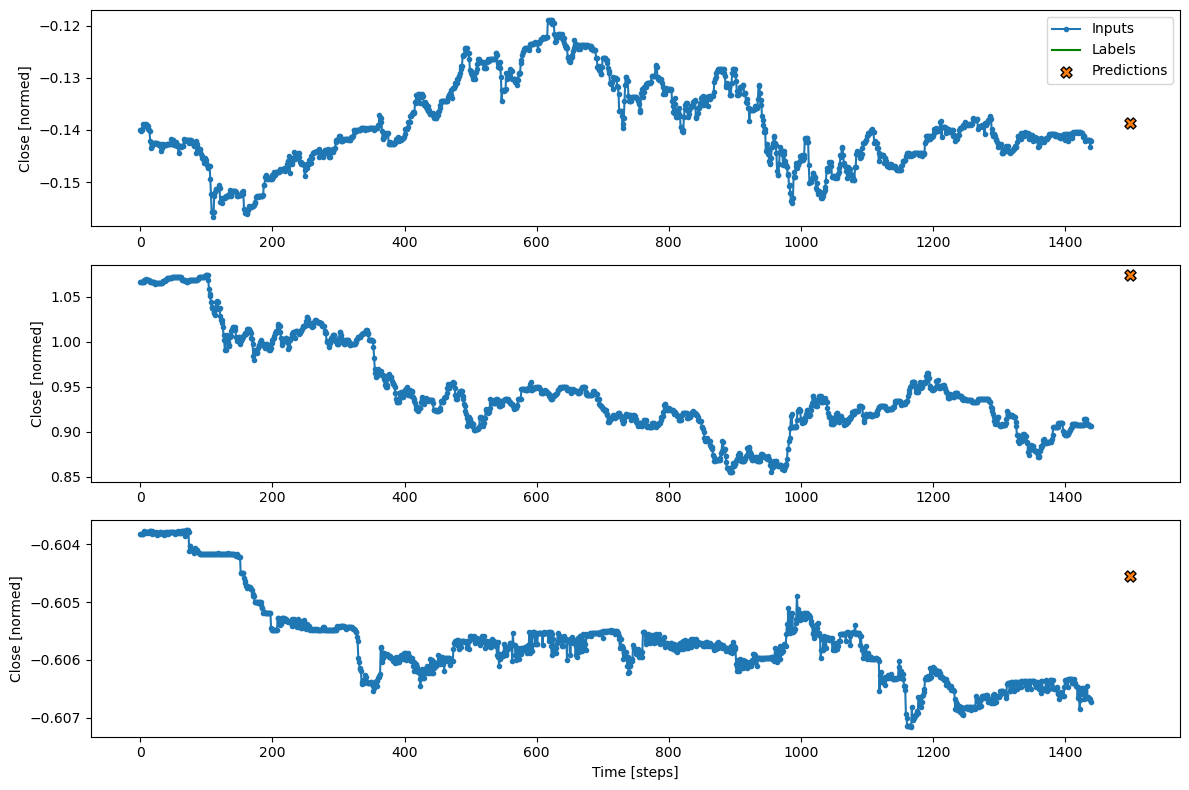

In [20]:
WindowGenerator.plot = plot
window.plot(model=linear_model, plot_col='Close')

##  Introducing the LSTM Model for Time Series Forecasting

While the linear model provides a simple baseline for predicting future values, it can only capture straightforward linear relationships between past and future data points.

However, time series data often contain complex temporal dependencies and patterns that evolve over time, such as trends, seasonality, and delayed effects. To capture these, we use **Recurrent Neural Networks (RNNs)**, specifically **Long Short-Term Memory (LSTM)** networks.

### Why LSTM?

* **LSTMs are designed to learn long-term dependencies** in sequential data by maintaining memory cells and gating mechanisms.
* They can **remember information for long periods** and decide which information to keep or discard.
* This makes them well-suited for time series forecasting, where past events influence the future in complex ways beyond simple linear relationships.

### What we will do:

* Define an LSTM-based neural network architecture.
* Train it on the same data window generator as the linear model.
* Evaluate and compare its performance.
* Visualize predictions against actual values to better understand model behavior.

This step will help us leverage temporal patterns in the data, potentially improving prediction accuracy.


In [22]:
"""
import tensorflow as tf

# Define the LSTM model architecture
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),   # 32 units, return last output
    tf.keras.layers.Dense(units=1)                      # Output layer for prediction
])

MAX_EPOCHS = 3 

def compile_and_fit(model, window, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min',
        restore_best_weights=True
    )
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )
    return history

# Train the LSTM model
history_lstm = compile_and_fit(lstm_model, window)
"""


"\nimport tensorflow as tf\n\n# Define the LSTM model architecture\nlstm_model = tf.keras.Sequential([\n    tf.keras.layers.LSTM(32, return_sequences=False),   # 32 units, return last output\n    tf.keras.layers.Dense(units=1)                      # Output layer for prediction\n])\n\nMAX_EPOCHS = 3 \n\ndef compile_and_fit(model, window, patience=3):\n    early_stopping = tf.keras.callbacks.EarlyStopping(\n        monitor='val_loss',\n        patience=patience,\n        mode='min',\n        restore_best_weights=True\n    )\n    model.compile(\n        loss=tf.keras.losses.MeanSquaredError(),\n        optimizer=tf.keras.optimizers.Adam(),\n        metrics=[tf.keras.metrics.MeanAbsoluteError()]\n    )\n    history = model.fit(\n        window.train,\n        epochs=MAX_EPOCHS,\n        validation_data=window.val,\n        callbacks=[early_stopping]\n    )\n    return history\n\n# Train the LSTM model\nhistory_lstm = compile_and_fit(lstm_model, window)\n"